## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import anndata
import matplotlib.pylab as plt
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

# Configuration

In [2]:
n_iters = 20_000

# Load data

In [3]:
location_fascicularis = '/home/nbarkas/disk2/deconvolution_method/datasets/nhp_fascicularis_atlas/h5ad/'

h5ad_paths = {
    # Ebov Datasets
    "bulk_blood": "ebov_bulk.h5ad",
    "sc_blood": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad",
    "bulk_all": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/all_ebov_bulk.h5ad",
    
    
    # fascicularis
    "sc_adrenal": f"{location_fascicularis}/Adrenal_gland.h5ad",
    "sc_cerebellum": f"{location_fascicularis}/Cerebellum.h5ad",
    "sc_kidney": f"{location_fascicularis}/Kidney.h5ad",
    "sc_liver": f"{location_fascicularis}/Liver.h5ad",
    "sc_lung": f"{location_fascicularis}/Lung.h5ad",
    "sc_lymph_node": f"{location_fascicularis}/Lymph_node.h5ad",
    "sc_neocortex": f"{location_fascicularis}/Neocortex.h5ad",
    "sc_pbmc": f"{location_fascicularis}/PBMC.h5ad",
    "sc_skin": f"{location_fascicularis}/Skin.h5ad",
    "sc_spleen": f"{location_fascicularis}/Spleen.h5ad",
    "sc_subcutaneous_adipose": f"{location_fascicularis}/Subcutaneous_adipose.h5ad",
    "sc_testis": f"{location_fascicularis}/Testis.h5ad",
    "sc_thyroid": f"{location_fascicularis}/Thyroid_gland.h5ad",
    "sc_uterus": f"{location_fascicularis}/Uterus.h5ad",
    "sc_vagina": f"{location_fascicularis}/Vagina.h5ad",
}

In [4]:
with open(h5ad_paths['bulk_all'], 'rb') as fh:
    all_bulk_anndata = anndata.read_h5ad(fh)

In [5]:
with open(h5ad_paths['sc_skin'], 'rb') as fh:
    sc_anndata_skin = anndata.read_h5ad(fh)

In [6]:
with open(h5ad_paths['sc_pbmc'], 'rb') as fh:
    sc_anndata_pbmc = anndata.read_h5ad(fh)

In [7]:
common_genes = list(set(sc_anndata_pbmc.var.index).intersection(set(sc_anndata_skin.var.index)))

In [8]:
sc_anndata_skin_subset = sc_anndata_skin[:,common_genes]
sc_anndata_pbmc_subset = sc_anndata_pbmc[:,common_genes]
sc_anndata = sc_anndata_skin_subset.concatenate(sc_anndata_pbmc_subset)

In [9]:
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['dpi_time'] >= -1e-6,]
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['full.tissue'].isin(['Skin','Skin:Non-Rash','Skin:Rash'])]

In [10]:
all_bulk_anndata.var.gene = all_bulk_anndata.var.gene.astype(str)
all_bulk_anndata.var = all_bulk_anndata.var.set_index('gene')

Trying to set attribute `.var` of view, copying.


In [11]:
datatype_param = DeconvolutionDatatypeParametrization()

In [12]:
ebov_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Abbreviation",
        bulk_anndata = all_bulk_anndata,
        bulk_time_col = "dpi_time",
        feature_selection_method = 'overdispersed_bulk_and_high_sc'
    )
)

/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.13916e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


log_sc_cutoff: 2
2840 genes selected


# Run Deconvolution

In [13]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
    dataset=ebov_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param)

In [14]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000, clear_param_store=False)

[step: 0, time: 1 s ] loss: 9774028.00
[step: 1000, time: 100 s ] loss: 3182082.07
[step: 2000, time: 215 s ] loss: 1291739.79
[step: 3000, time: 335 s ] loss: 724248.83
[step: 4000, time: 455 s ] loss: 528843.46
[step: 5000, time: 579 s ] loss: 447087.47
[step: 6000, time: 707 s ] loss: 409409.40
[step: 7000, time: 834 s ] loss: 389692.57
[step: 8000, time: 961 s ] loss: 379480.58
[step: 9000, time: 1092 s ] loss: 373954.70
[step: 10000, time: 1227 s ] loss: 370902.47
[step: 11000, time: 1354 s ] loss: 369116.41
[step: 12000, time: 1462 s ] loss: 368040.46
[step: 13000, time: 1549 s ] loss: 367247.21
[step: 14000, time: 1640 s ] loss: 366561.40
[step: 15000, time: 1731 s ] loss: 366019.30
[step: 16000, time: 1810 s ] loss: 365710.17
[step: 17000, time: 1862 s ] loss: 365529.39
[step: 18000, time: 1907 s ] loss: 365403.56
[step: 19000, time: 1954 s ] loss: 365325.53


# Examine Outputs

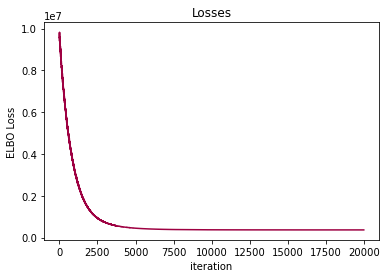

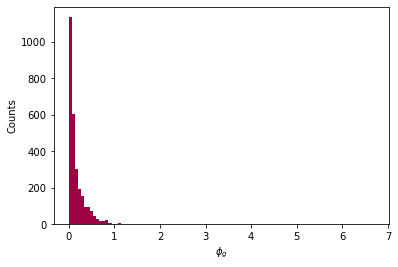

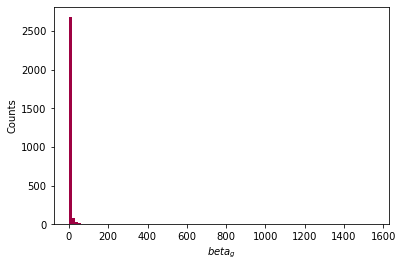

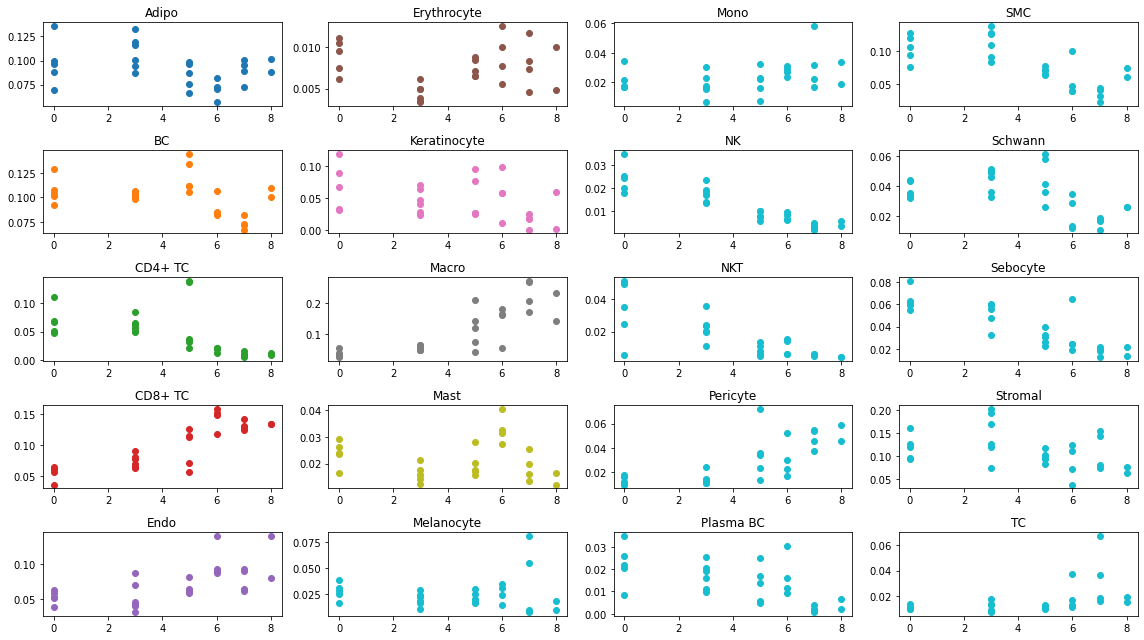

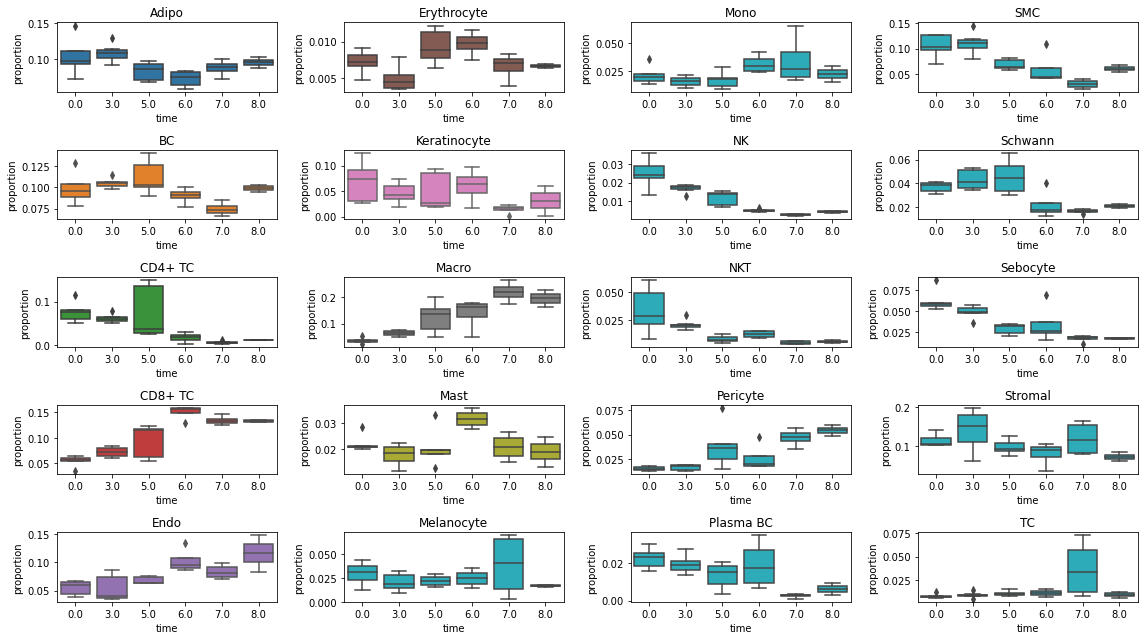

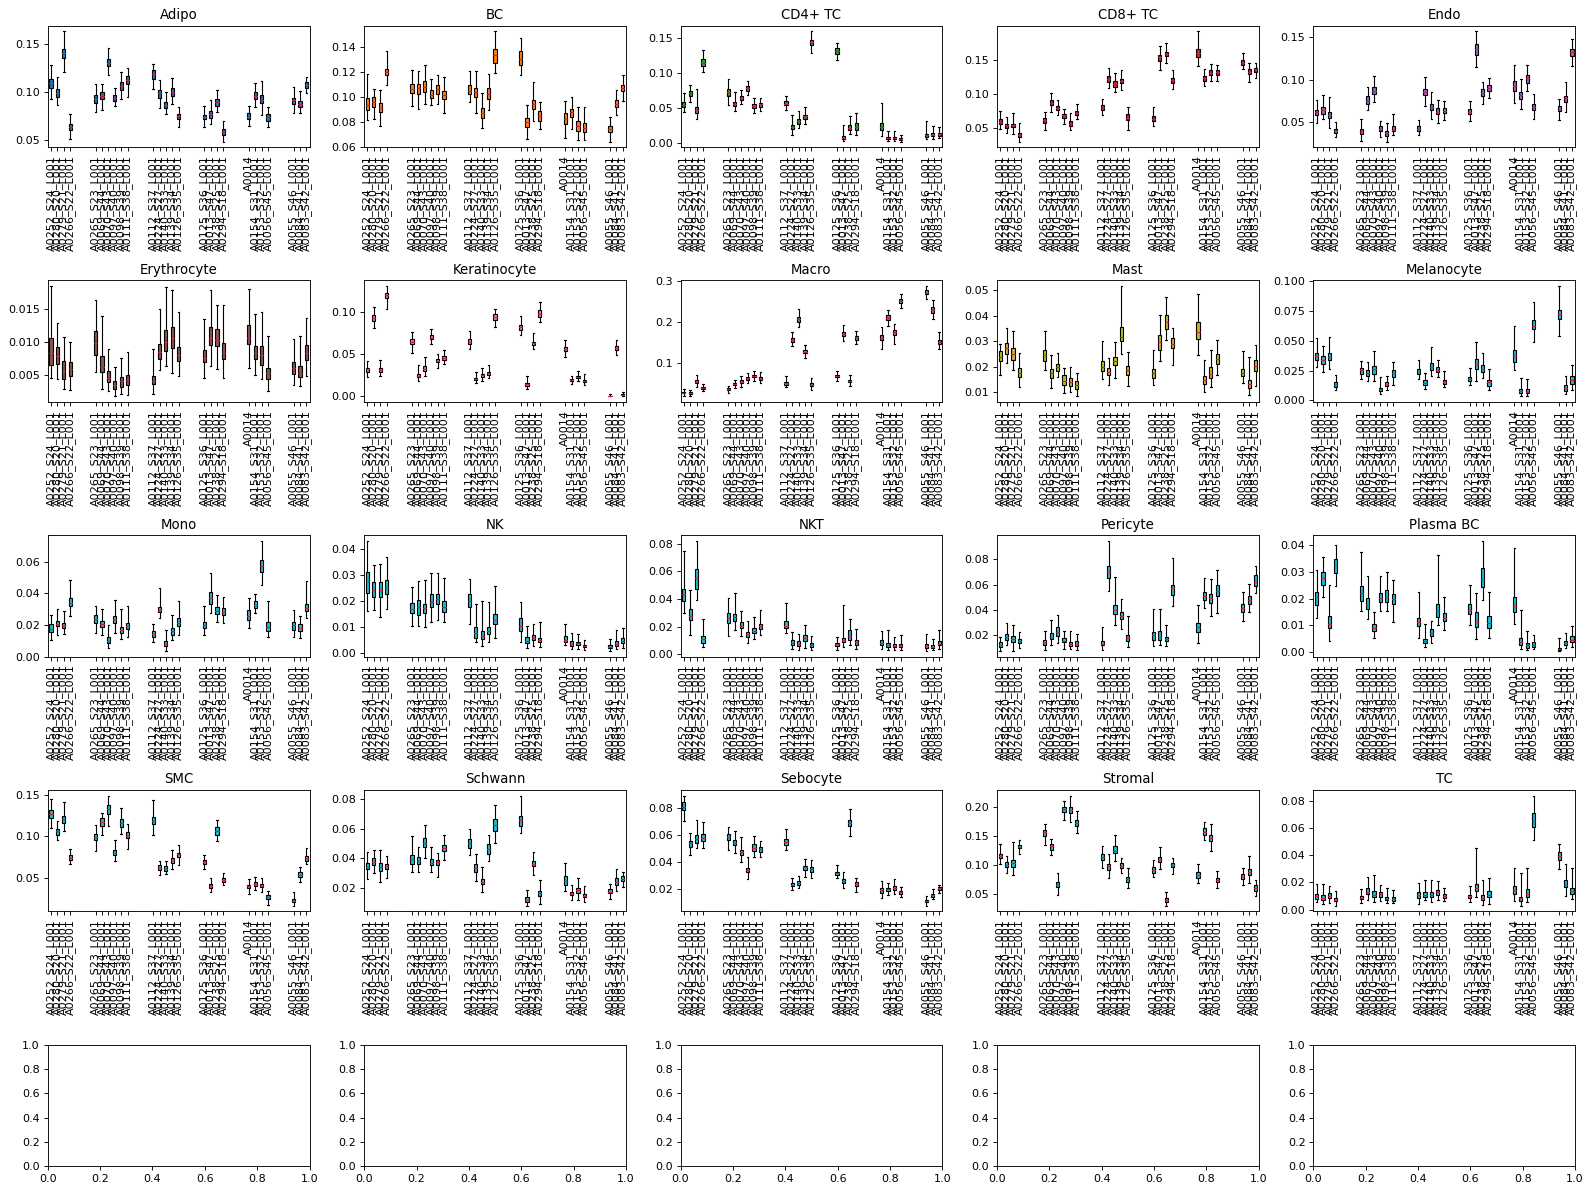

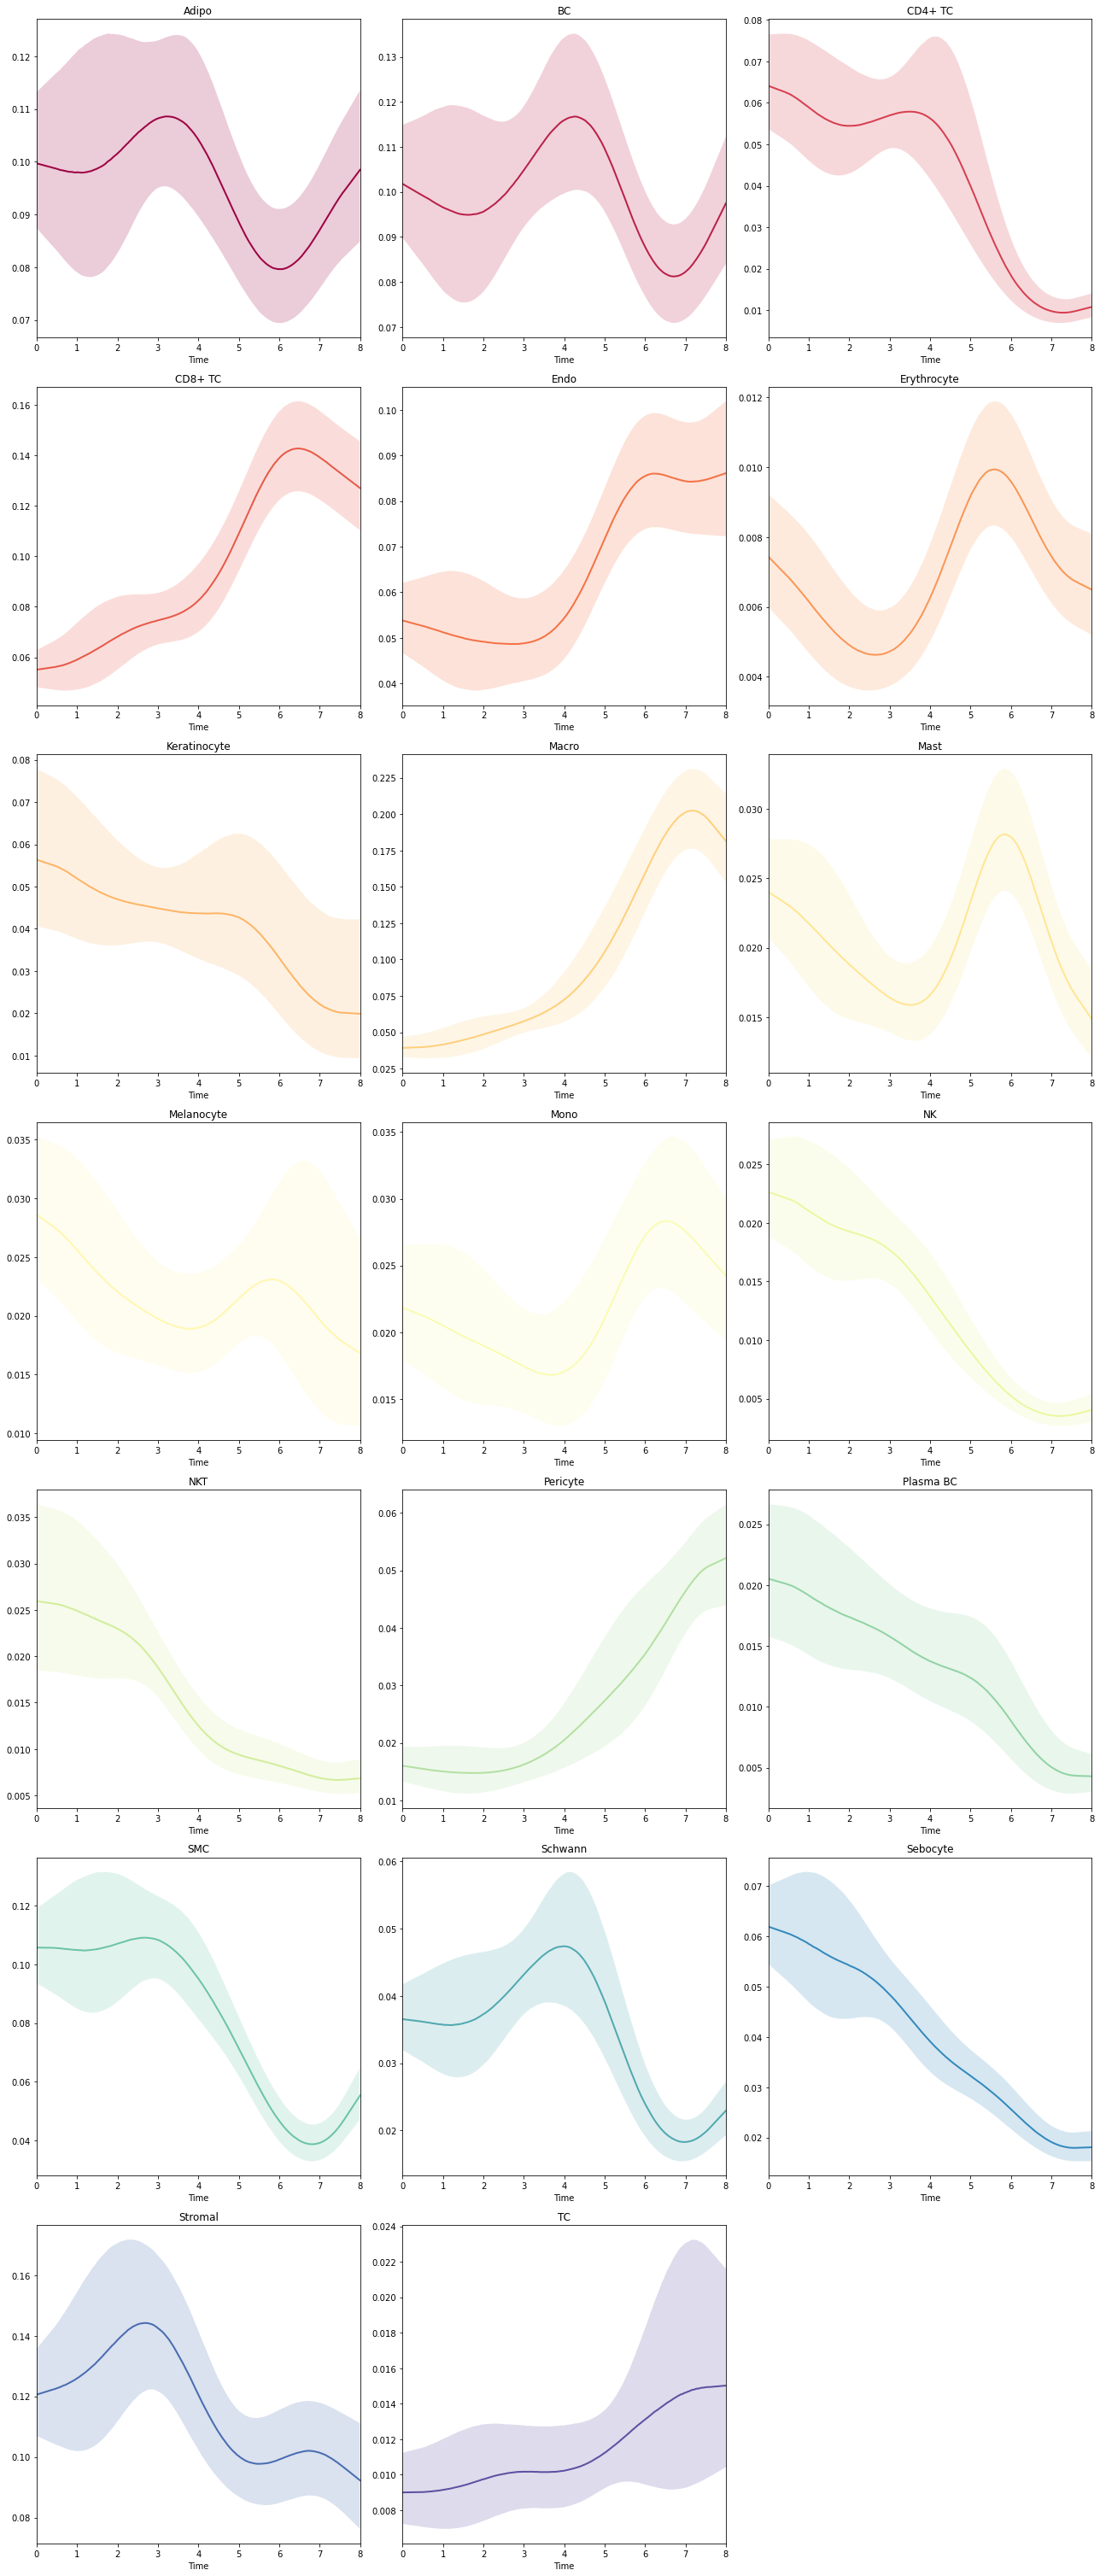

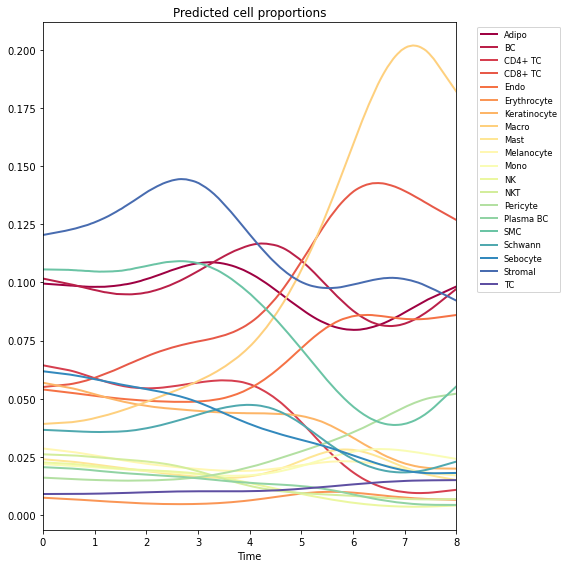

In [16]:
exporter = DeconvolutionExporter(pseudo_time_reg_deconv, prefix = 'skin_')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.linspace(0,1,pseudo_time_reg_deconv.dataset.num_cell_types)))
exporter.export_results('output/skin/')

# Blood VS Non-blood

In [17]:
# Generate cell summarization
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.linspace(0,1,4)))
ctsum = {
    'Blood': list(sc_anndata_pbmc_subset.obs.Abbreviation.unique()),
    'Tissue': list(sc_anndata_skin_subset.obs.Abbreviation.unique())
}

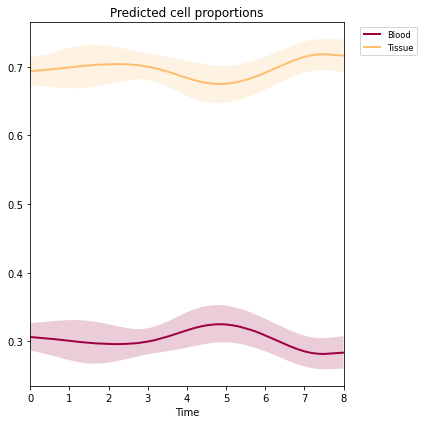

In [18]:
exporter.plotter.plot_composition_trajectories_via_posterior_sampling(
    iqr_alpha=0.2,
    show_combined=True,
    ncols=3,
    lw=2.,
    figsize=(6,6),
    sharey=False,
    celltype_summarization=ctsum,
    filenames = ('output/skin/blood_vs_tissue.png',
        'output/skin/blood_vs_tissue.pdf')
)

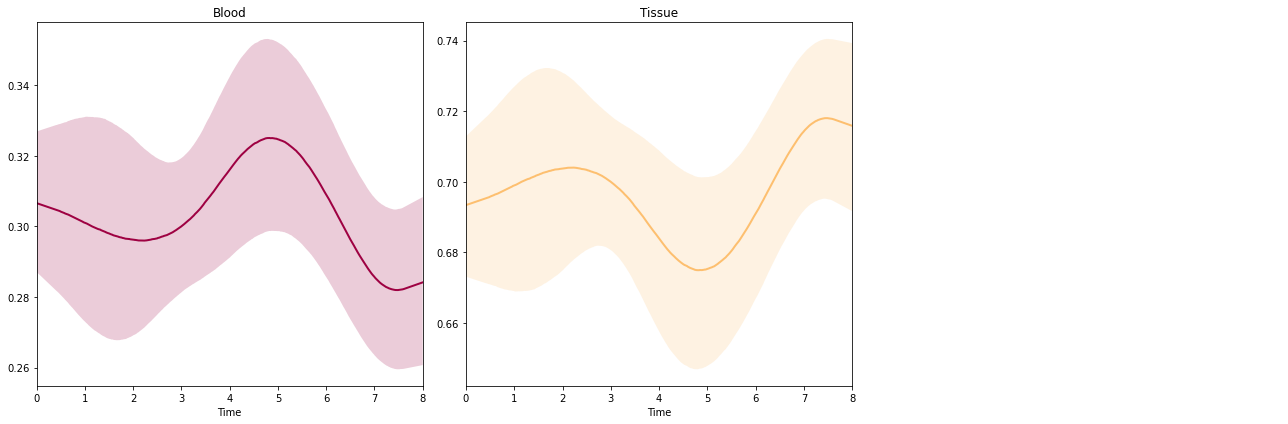

In [19]:
exporter.plotter.plot_composition_trajectories_via_posterior_sampling(
    iqr_alpha=0.2,
    show_combined=False,
    ncols=3,
    lw=2.,
    figsize=(6,6),
    sharey=False,
    celltype_summarization=ctsum,
    filenames = ('output/skin/blood_vs_tissue_individual.png',
        'output/skin/blood_vs_tissue_individual.pdf')
)

# With Monocytes separate

In [22]:
ctsum = {
    'Mono': ['Mono'],
    'Blood': ['Plasma BC',
  'BC',
  'CD4+ TC',
  'Erythrocyte',
  'CD8+ TC',
  'NK',
  'NKT'],
 'Tissue': ['Stromal',
  'Endo',
  'Keratinocyte',
  'SMC',
  'Sebocyte',
  'NK',
  'TC',
  'Macro',
  'Adipo',
  'Melanocyte',
  'Pericyte',
  'Schwann',
  'Mast']}

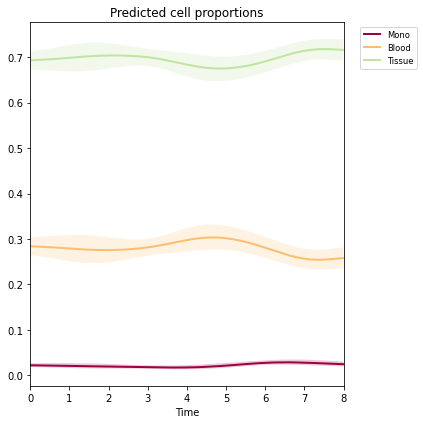

In [23]:
exporter.plotter.plot_composition_trajectories_via_posterior_sampling(
    iqr_alpha=0.2,
    show_combined=True,
    ncols=3,
    lw=2.,
    figsize=(6,6),
    sharey=False,
    celltype_summarization=ctsum,
    filenames = ('output/skin/mono_vs_blood_vs_tissue.png',
        'output/skin/mono_vs_blood_vs_tissue.pdf')
)

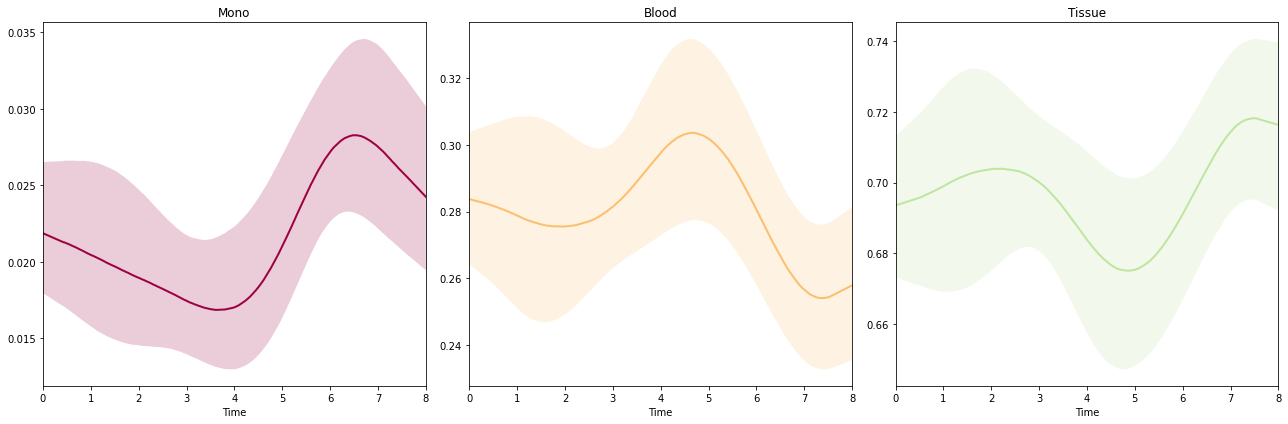

In [24]:
exporter.plotter.plot_composition_trajectories_via_posterior_sampling(
    iqr_alpha=0.2,
    show_combined=False,
    ncols=3,
    lw=2.,
    figsize=(6,6),
    sharey=False,
    celltype_summarization=ctsum,
    filenames = ('output/skin/mono_vs_blood_vs_tissue_individual.png',
        'output/skin/mono_vs_blood_vs_tissue_individual.pdf')
)